# Statistical analysis of a production day using Rhize

Thursday was a bad day at the plant. But how bad was it? To find out, integrate Rhize with a Jupyter notebook and do some statistical analysis.

## Set up

First, import the Python libraries that you'll use for statistical analysis:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


### Get your token

Use `subprocess` to run the `get_token` shell script:

In [2]:
import subprocess
import json

def get_token():
    try:
        result = subprocess.run(['bash', 'get_token.sh'], capture_output=True, text=True, check=True)
        token = json.loads(result.stdout.strip())
        
        return token['access_token']
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e}")
        return None

token = get_token()


## Query Job responses from date range

This uses a GraphQL [query](https://docs.rhize.com/how-to/gql/query/) to get job responses from the Rhize API. It [filters](https://docs.rhize.com/how-to/gql/filter/] by ID to match a regular expression and by endDateTime to match a defined range.

5 queries execute in total, one for each defined day. Each day is bucketed into its own list.

In [3]:
import requests


url = 'http://localhost:4000/'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {token}'
}

# Function to create the query data
def query_job_responses(date):
    return {
        "query":
            """
            query($filter: JobResponseFilter){
                queryJobResponse(filter: $filter){
                    id
                    duration
                    startDateTime
                    endDateTime
                }
            }
            """,
        "variables": {
            "filter": {
                "id": {"regexp": "/ds1.?-batch/"},
                "endDateTime": {
                    "between": {
                        "min": f"{date}T00:00:00.00Z",
                        "max": f"{date}T23:59:59.99Z"
                    }
                }
            }
        }
    }

# List of dates for the requests
dates = [
    "2024-09-19",
    "2024-09-20",
    "2024-09-21",
    "2024-09-22",
    "2024-09-23"
]

# List to store job responses
job_responses = []

# Make the POST requests
for date in dates:
    data = query_job_responses(date)
    response = requests.post(url, headers=headers, json=data)
    job_response = response.json().get('data', {}).get('queryJobResponse', [])
    job_responses.append(job_response)

monday_jobs, tuesday_jobs, wednesday_jobs, thursday_jobs, friday_jobs = job_responses
job_responses = monday_jobs + tuesday_jobs + wednesday_jobs + thursday_jobs + friday_jobs


Optionally inspect a slice of the data:

In [4]:
thursday_jobs[2:4]

[{'id': 'ds1c-batch-68-jr-fc-make-frosting',
  'duration': 975.999,
  'startDateTime': '2024-09-22T23:09:51Z',
  'endDateTime': '2024-09-22T23:26:06.999Z'},
 {'id': 'ds1c-batch-1-jr-fc-make-frosting',
  'duration': 956.634,
  'startDateTime': '2024-09-22T23:09:51Z',
  'endDateTime': '2024-09-22T23:25:47.634Z'}]

## Analyze: does this data look normal?

### Plot a histogram of all data

Plot all job-response durations for the week to see if the histogram looks normal.

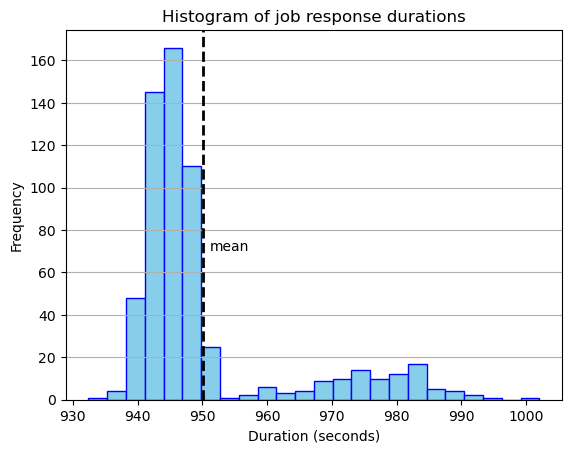

In [5]:

# set durations
durations = [item['duration'] for item in job_responses]
mean = np.mean(durations)

# Create the histogram
plt.hist(durations, bins=len(job_responses)//25, color='skyblue', edgecolor='blue')

# Add labels and title
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of job response durations')

# Show the plot
plt.grid(axis='y', alpha=1)
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2)
plt.text(mean+1,70,'mean',color='black')
plt.show()


### Make a box plot of each day

Now make a [box plot](https://en.wikipedia.org/wiki/Box_plot) to compare the spread of job response durations across days:

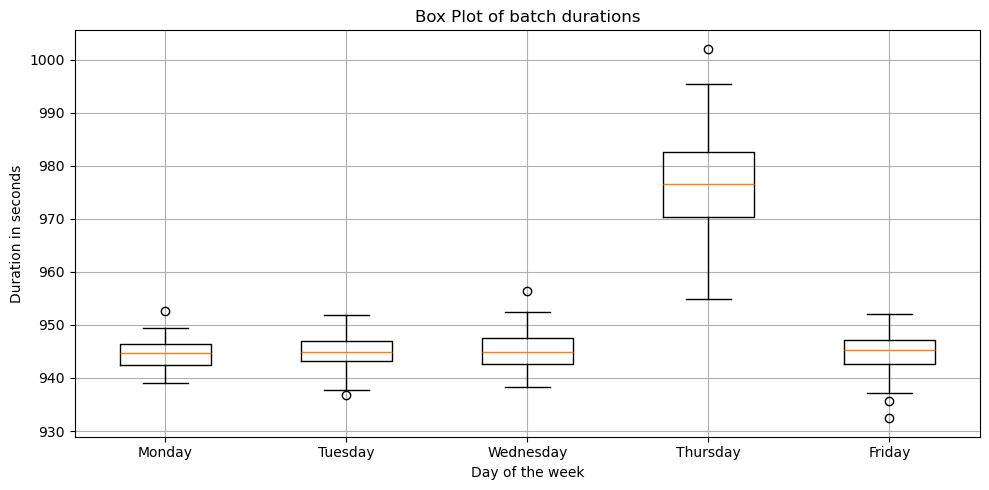

In [6]:
monday_durations = [job['duration'] for job in monday_jobs]
tuesday_durations = [job['duration'] for job in tuesday_jobs]
wednesday_durations = [job['duration'] for job in wednesday_jobs]
thursday_durations = [job['duration'] for job in thursday_jobs]
friday_durations = [job['duration'] for job in friday_jobs]


plt.figure(figsize=(10, 5))  # Set the figure size

plt.boxplot([monday_durations, tuesday_durations,wednesday_durations,thursday_durations,friday_durations],
            tick_labels=['Monday','Tuesday','Wednesday','Thursday','Friday'])

# Add title and labels
plt.title('Box Plot of batch durations')
plt.xlabel('Day of the week')
plt.ylabel('Duration in seconds')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


## Run a t-test to determine if difference is significant

The value of the population mean is known, `945`.
 So you can run a one-sample t-test to test whether the sample mean, `thursday_jobs`, matches the population mean.

### First check: is the distribution normal? 

Plot the same histogram, but only for thursday:


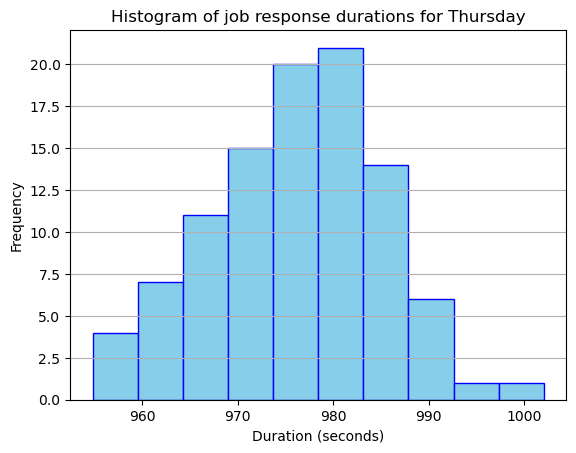

In [7]:
thursday_durations = [item['duration'] for item in thursday_jobs]


# Create the histogram
plt.hist(thursday_durations, bins=10, color='skyblue', edgecolor='blue')

# Add labels and title
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of job response durations for Thursday')

# Show the plot
plt.grid(axis='y', alpha=1)
plt.show()

We can also run a [Shapiro-Wilk](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) test for the null hypothesis.


In [8]:
stats.shapiro(thursday_durations)


ShapiroResult(statistic=np.float64(0.987984489252489), pvalue=np.float64(0.5070641756271144))

The data appears to be normally distributed.

Use SciPy to calculate a [1 sample t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html).

In [9]:
# Run t-test against known population mean

t_statistic, p_value = stats.ttest_1samp(thursday_durations, 945)


print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference in means is statistically significant. Reject the null")
else:
    print("P-value is high, difference in means is not statistically significant. Fail to reject the null")

T-statistic: 34.691797986482264
P-value: 3.326125428955796e-57
The difference in means is statistically significant. Reject the null




## Next steps

- Run a track and trace query for the jobs of Thursday.
- Create a BPMN workflow to automatically send alerts about abberant days


> **ManuFact**:
>The t-test was invented to observe the quality of [samples in batch manufacturing](https://en.wikipedia.org/wiki/Student%27s_t-test#History).
>Thanks, William Gosset!
